In [1]:
from GT import get_dataset
import matplotlib.pyplot as plt
from GT import GTM
import json
import torch
import numpy as np
import pandas as pd
import os
import seaborn as sns



DATASET_NAME = 'Synth'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 64
num_layers = 1
lr = 0.001
weight_decay = 0.01
# weight_decay = 0
dropout = 0.1
bidirectional = True
mixture_dim = 10
debug = False
train_from_checkpoint = False
dataset = get_dataset()

Synth DATA
Original Dataset: 	1494
Train Split: 		498 	(70%)
Validation Split: 	498 	(20%)
Test Split: 		498 	(10%)


## Dataset

In [4]:
# Dataset Split\
Train, Validation, Test = get_dataset('Synth')

train_data = Train
train_data = torch.Tensor(train_data)
exo_var = []

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)
exo_size = len(exo_var)
Train.shape

Synth DATA
Original Dataset: 	1494
Train Split: 		498 	(70%)
Validation Split: 	498 	(20%)
Test Split: 		498 	(10%)


(498, 63, 6)

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_85909/356130559.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})


<Axes: ylabel='Density'>

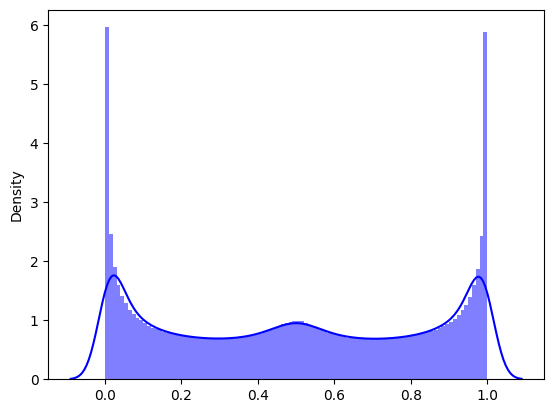

In [5]:
sns.distplot(train_data, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})

## Model Train

In [6]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, window=15, horizon=3, epochs=20)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_85909/1580261469.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

Model not present or incompatible
Starting training...


Loss 2.317945331694132: 100%|██████████| 498/498 [00:22<00:00, 22.61it/s] 


Epoch 1 - loss: 2.317945331694132


Loss 1.5599378752241653: 100%|██████████| 498/498 [00:28<00:00, 17.49it/s]


Epoch 2 - loss: 1.5599378752241653


Loss 1.1347379515239273: 100%|██████████| 498/498 [00:21<00:00, 22.83it/s]


Epoch 3 - loss: 1.1347379515239273


Loss 0.9014654341696137: 100%|██████████| 498/498 [00:21<00:00, 22.87it/s]


Epoch 4 - loss: 0.9014654341696137


Loss 0.7983266668371767: 100%|██████████| 498/498 [00:21<00:00, 22.88it/s]


Epoch 5 - loss: 0.7983266668371767


Loss 0.719794946599258: 100%|██████████| 498/498 [00:21<00:00, 22.80it/s] 


Epoch 6 - loss: 0.719794946599258


Loss 0.6518160863498966: 100%|██████████| 498/498 [00:21<00:00, 22.81it/s]


Epoch 7 - loss: 0.6518160863498966


Loss 0.5912540780247589: 100%|██████████| 498/498 [00:21<00:00, 22.89it/s]


Epoch 8 - loss: 0.5912540780247589


Loss 0.5399534807199879: 100%|██████████| 498/498 [00:21<00:00, 22.97it/s]


Epoch 9 - loss: 0.5399534807199879


Loss 0.4955609037879112: 100%|██████████| 498/498 [00:21<00:00, 22.90it/s] 


Epoch 10 - loss: 0.4955609037879112


Loss 0.44788205958184885: 100%|██████████| 498/498 [00:21<00:00, 22.83it/s]


Epoch 11 - loss: 0.44788205958184885


Loss 0.4060074632695129: 100%|██████████| 498/498 [00:21<00:00, 22.96it/s] 


Epoch 12 - loss: 0.4060074632695129


Loss 0.37233029394678213: 100%|██████████| 498/498 [00:21<00:00, 22.88it/s]


Epoch 13 - loss: 0.37233029394678213


Loss 0.3453061954540931: 100%|██████████| 498/498 [00:21<00:00, 22.79it/s] 


Epoch 14 - loss: 0.3453061954540931


Loss 0.3186378508935779: 100%|██████████| 498/498 [00:21<00:00, 22.86it/s] 


Epoch 15 - loss: 0.3186378508935779


Loss 0.3013181707393831: 100%|██████████| 498/498 [00:21<00:00, 22.94it/s] 


Epoch 16 - loss: 0.3013181707393831


Loss 0.27286426874411973: 100%|██████████| 498/498 [00:21<00:00, 22.87it/s]


Epoch 17 - loss: 0.27286426874411973


Loss 0.2473858495958699: 100%|██████████| 498/498 [00:21<00:00, 22.96it/s] 


Epoch 18 - loss: 0.2473858495958699


Loss 0.22997430277050387: 100%|██████████| 498/498 [00:21<00:00, 22.89it/s]


Epoch 19 - loss: 0.22997430277050387


Loss 0.20740760397832428: 100%|██████████| 498/498 [00:21<00:00, 22.86it/s]

Epoch 20 - loss: 0.20740760397832428


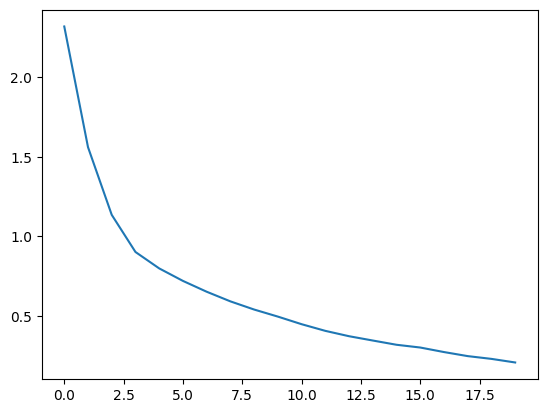

<Figure size 640x480 with 0 Axes>

In [7]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

In [15]:
from Notebooks.Eval.VisualEval import plot_pca

output = model.generate_step(shape=(1, 63, 6), window=15, horizon=3)
output1 = model.generate_step(shape=(1, 63, 6), window=15)
prediction = model.predict_step(train_data[0:1], steps=63)

100%|██████████| 63/63 [00:00<00:00, 111.22it/s]


/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_85909/356130559.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})


<Axes: ylabel='Density'>

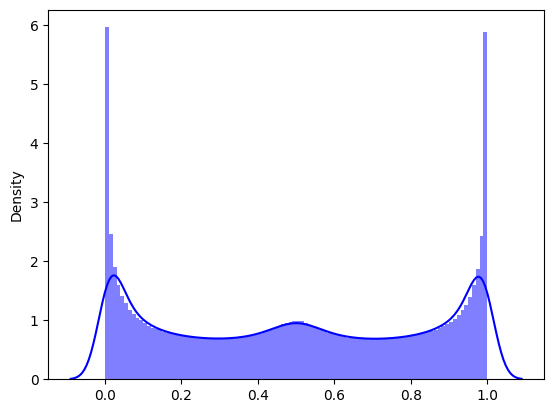

In [16]:
sns.distplot(train_data, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_85909/1987323760.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})


<Axes: ylabel='Density'>

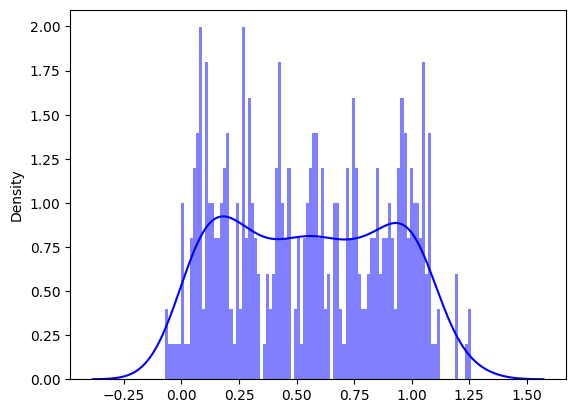

In [17]:
sns.distplot(output, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})


/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_85909/2365403536.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output1, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})


<Axes: ylabel='Density'>

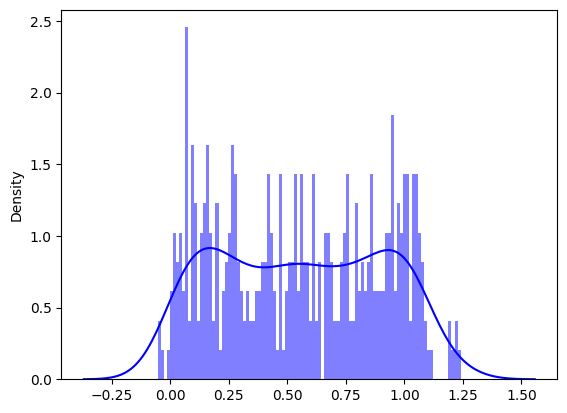

In [18]:
sns.distplot(output1, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})

In [19]:
output.shape

(1, 63, 6)

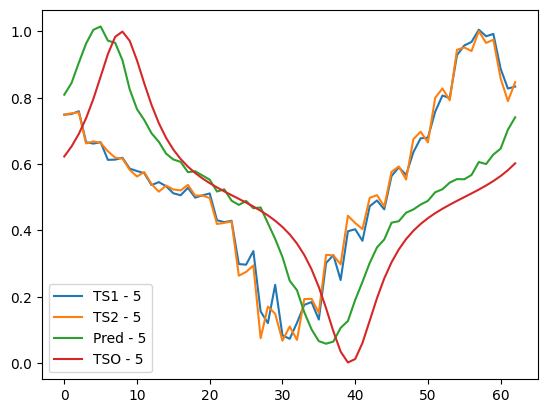

In [20]:
# plt.plot(output[0, :, 0], label='TS1 - 0')
# plt.plot(output[0, :, 1], label='TS1 - 1')
# plt.plot(output[0, :, 2], label='TS1 - 2')
# plt.plot(output[0, :, 3], label='TS1 - 3')
# plt.plot(output[0, :, 4], label='TS1 - 4')
plt.plot(output[0, :, 5], label='TS1 - 5')

# plt.plot(output1[0, :, 0], label='TS2 - 0')
# plt.plot(output1[0, :, 1], label='TS2 - 1')
# plt.plot(output1[0, :, 2], label='TS2 - 2')
# plt.plot(output1[0, :, 3], label='TS2 - 3')
# plt.plot(output1[0, :, 4], label='TS2 - 4')
plt.plot(output1[0, :, 5], label='TS2 - 5')


# plt.plot(prediction[0, :, 0], label='Pred - 0')
# plt.plot(prediction[0, :, 1], label='Pred - 1')
# plt.plot(prediction[0, :, 2], label='Pred - 2')
# plt.plot(prediction[0, :, 3], label='Pred - 3')
# plt.plot(prediction[0, :, 4], label='Pred - 4')
plt.plot(prediction[0, :, 5], label='Pred - 5')


# plt.plot(train_data[0, :, 0], label='TSO - 0')
# plt.plot(train_data[0, :, 1], label='TSO - 1')
# plt.plot(train_data[0, :, 2], label='TSO - 2')
# plt.plot(train_data[0, :, 3], label='TSO - 3')
# plt.plot(train_data[0, :, 4], label='TSO - 4')
plt.plot(train_data[0, :, 5], label='TSO - 5')
plt.legend()
plt.show()

3


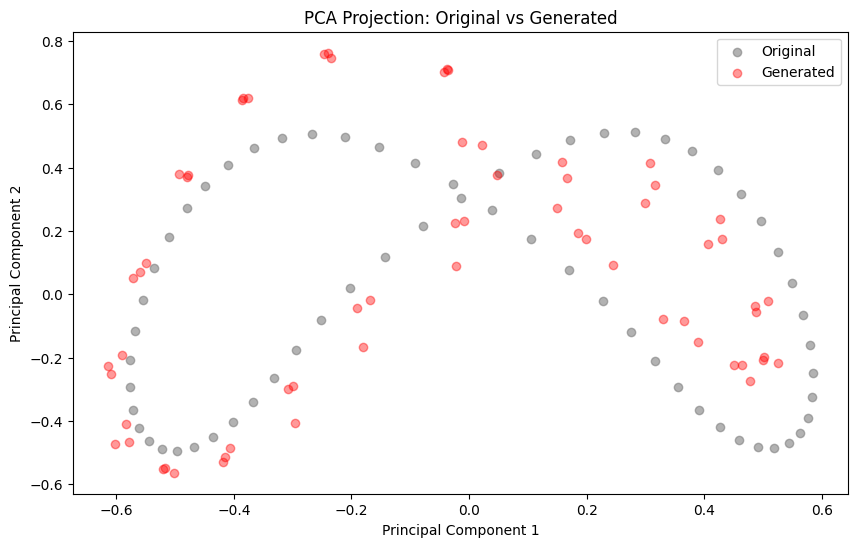

3


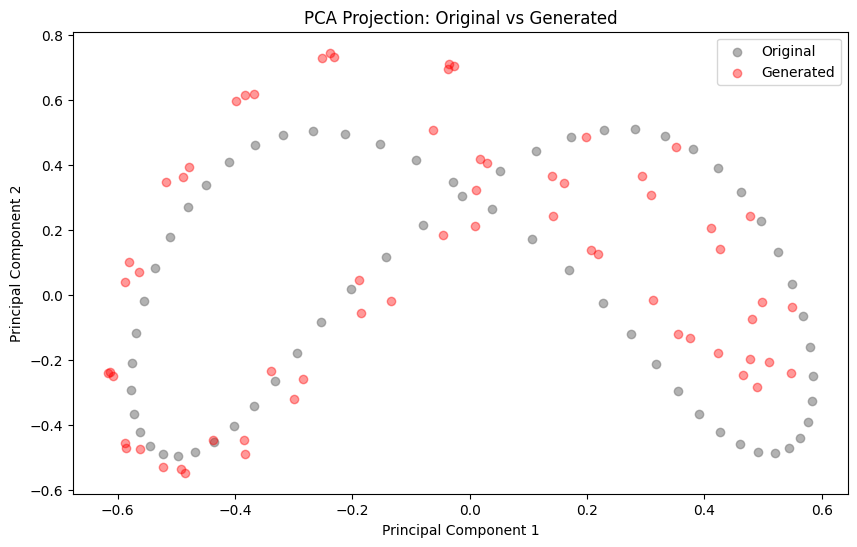

3


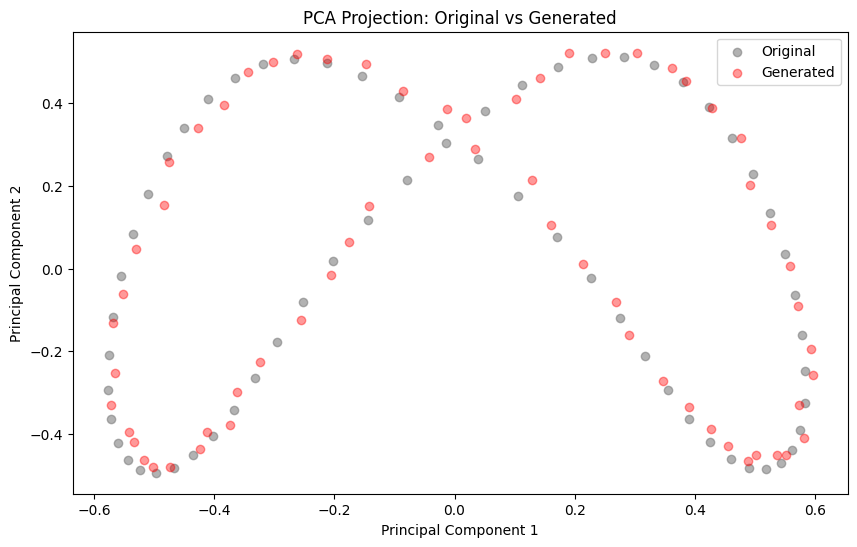

In [21]:
# plot_pca(train_data[-2], output[0], component_to_plot=(0, 1))
plot_pca(train_data[-2], output[0], component_to_plot=(1, 2))
# plot_pca(train_data[-2], output1[0], component_to_plot=(0, 1))
plot_pca(train_data[-2], output1[0], component_to_plot=(1, 2))
plot_pca(train_data[-2], prediction[0], component_to_plot=(1, 2))
# plot_tsne(data_true, data_generated)